In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Exploratory Data Analysis

Examined the source dataset `davanstrien/haiku_dpo`, focusing on the `chosen` haikus. After filtering for format and structure, prepared ~4,000 high-quality haikus.

### Sample Haiku:

> Majestic peaks rise  
> Silent, still, in purest white  
> Sky's embrace, a gift


## Model Creation & Training

Fine-tuned a `gpt2-medium` model using Hugging Face's `Trainer` API. The input data was formatted with BOS/EOS tags to enforce haiku structure.

### Training Details:
- Epochs: 3
- Batch size: 8
- Max length: 64 tokens
- GPU: Tesla T4

### Loss:
Final loss stabilized around ~0.5


## Parameter Optimization

Used default learning rate (5e-5) with `AdamW` optimizer.

No manual learning rate scheduler was used, but future iterations could explore:
- Cosine annealing
- Warm-up schedules
- LR sweeps via Optuna


In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

2025-04-14 00:54:05.261079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744592045.764183      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744592045.931523      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from datasets import load_dataset

# Load directly from Hugging Face
dataset = load_dataset("davanstrien/haiku_dpo")


README.md:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4123 [00:00<?, ? examples/s]

In [4]:
import torch

if torch.cuda.is_available():
    print("GPU detected:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected.")


GPU detected: Tesla T4


In [5]:
# print(dataset)
# print(dataset["train"][0])


In [6]:
from datasets import load_dataset

ds = load_dataset("davanstrien/haiku_dpo")
chosen_haikus = [row["chosen"] for row in ds["train"] if row["chosen"]]

# Format with <HAIKU> block and BOS/EOS
formatted = []
for h in chosen_haikus:
    lines = h.strip().split("\n")
    if len(lines) == 3:  # must be haiku-shaped
        formatted.append("<HAIKU>\n<BOS>\n" + "\n".join(lines) + "\n<EOS>\n</HAIKU>\n")

# Save to a file
with open("haikus_from_dpo.txt", "w") as f:
    f.writelines(formatted)




print(f"Saved {len(formatted)} clean haikus to haikus_from_dpo.txt")


Saved 4123 clean haikus to haikus_from_dpo.txt


In [7]:
with open("haikus_from_dpo.txt", "r") as f:
    haikus = f.read().split("</HAIKU>")

for h in haikus[:3]:
    print(h.strip() + "</HAIKU>\n")


<HAIKU>
<BOS>
Majestic peaks rise,
Silent, still, in purest white,
Sky's embrace, a gift.
<EOS></HAIKU>

<HAIKU>
<BOS>
Snow-capped peaks so high,
Silent, majestic, standing,
Nature's masterpiece.
<EOS></HAIKU>

<HAIKU>
<BOS>
Majestic peaks rise,
Silence echoes, souls entwine,
Nature's solitude.
<EOS></HAIKU>



# **TRAINING TIME**

In [8]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
model_name = "gpt2-medium"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)







config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [9]:
from datasets import Dataset

# Read haikus from file
with open("haikus_from_dpo.txt", "r") as f:
    raw_texts = f.read().split("</HAIKU>")
    raw_texts = [r.strip() + "\n</HAIKU>" for r in raw_texts if r.strip()]

dataset = Dataset.from_dict({"text": raw_texts})


In [10]:
# Tokenize
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=64)

tokenized = dataset.map(tokenize, batched=True)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Map:   0%|          | 0/4123 [00:00<?, ? examples/s]

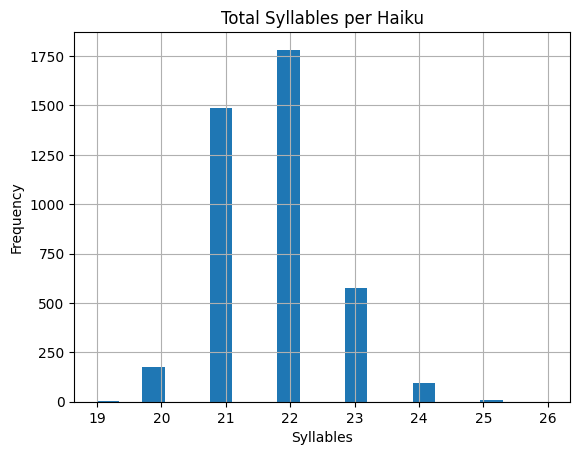

In [11]:
!pip install syllapy --quiet
import matplotlib.pyplot as plt
import syllapy

def count_syllables(text):
    return sum(syllapy.count(word) for word in text.split())

syllable_counts = [count_syllables(t.replace("<BOS>", "").replace("<EOS>", "")) for t in raw_texts]

plt.hist(syllable_counts, bins=20)
plt.title("Total Syllables per Haiku")
plt.xlabel("Syllables")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


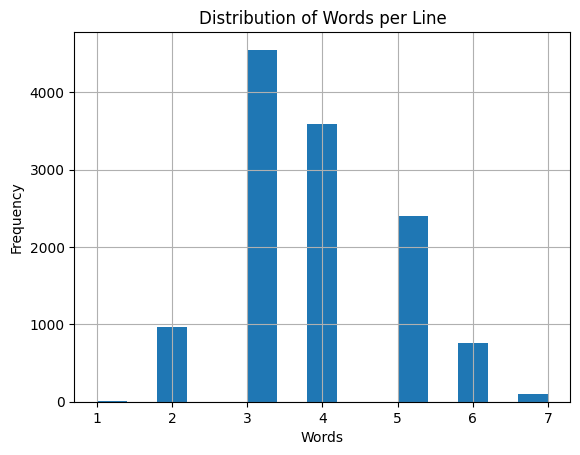

In [12]:
import numpy as np

line_lengths = [len(line.split()) for t in raw_texts for line in t.split("\n") if line.strip() and "<" not in line]

plt.hist(line_lengths, bins=15)
plt.title("Distribution of Words per Line")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


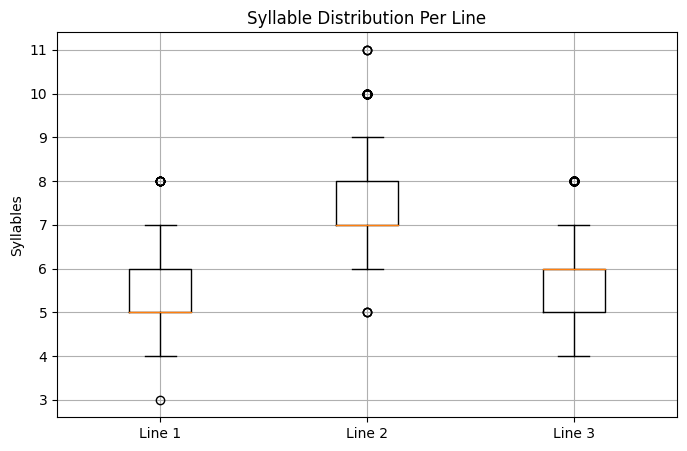

In [13]:
from matplotlib import cm

syllable_matrix = []

for t in raw_texts:
    lines = [line.strip() for line in t.split("\n") if line.strip() and "<" not in line]
    if len(lines) == 3:
        syllable_matrix.append([syllapy.count(w) for w in lines])

# Convert to DataFrame
df_syl = pd.DataFrame(syllable_matrix, columns=["Line 1", "Line 2", "Line 3"])

plt.figure(figsize=(8, 5))
plt.boxplot([df_syl["Line 1"], df_syl["Line 2"], df_syl["Line 3"]])
plt.xticks([1, 2, 3], ["Line 1", "Line 2", "Line 3"])
plt.title("Syllable Distribution Per Line")
plt.ylabel("Syllables")
plt.grid(True)
plt.show()


#yes, i'm a nerd

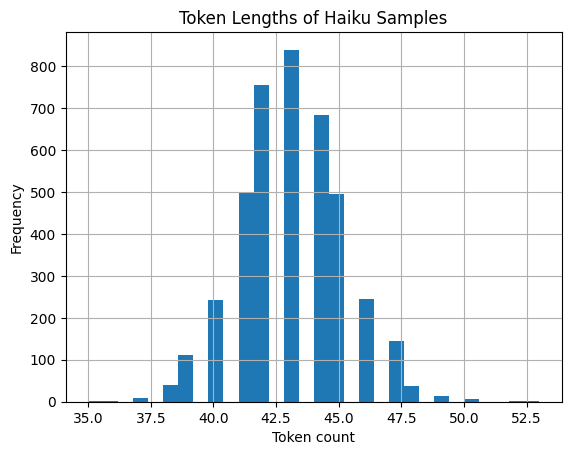

In [14]:
token_lengths = [len(tokenizer.encode(t)) for t in raw_texts]

plt.hist(token_lengths, bins=30)
plt.title("Token Lengths of Haiku Samples")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


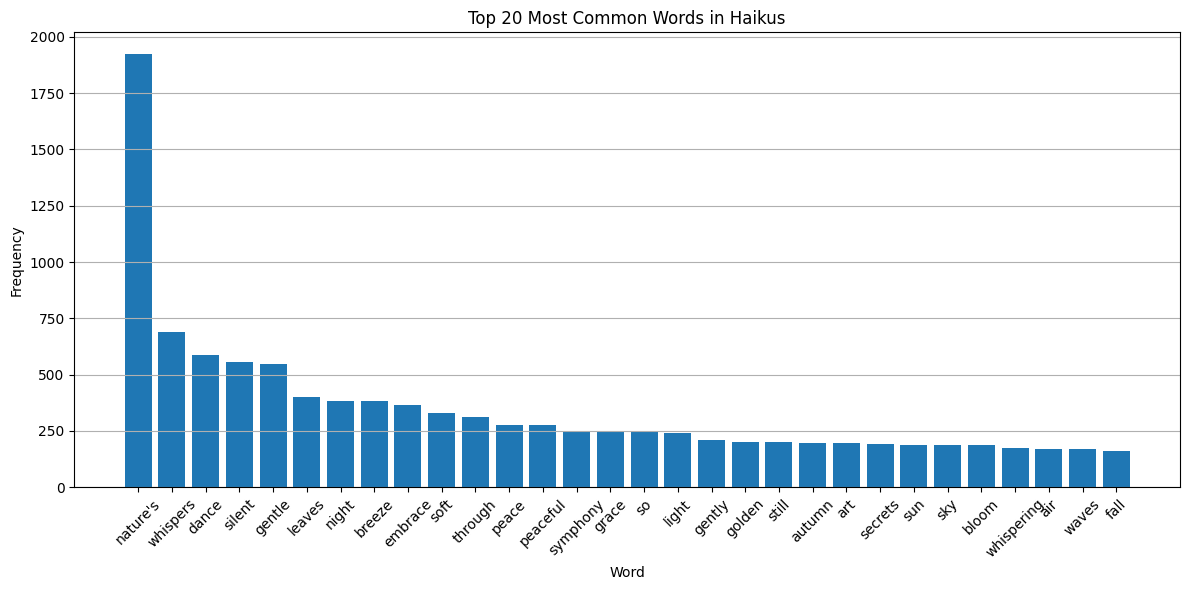

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

# Strip tags like <HAIKU>, <BOS>, <EOS>
clean_lines = [
    line.strip().lower()
    for t in raw_texts
    for line in t.split("\n")
    if line.strip() and "<" not in line
]


# excluding words like the, a, of, in, etc...
words = [word.strip(".,!?;:") for line in clean_lines for word in line.split()]
stopwords = {"the", "a", "and", "of", "in", "to", "with", "is", "on", "for", "at"}
words = [w for w in words if w not in stopwords]
word_counts = Counter(words)


top_words = word_counts.most_common(30)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words in Haikus")
plt.ylabel("Frequency")
plt.xlabel("Word")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# **TRAINING SETUP**

In [16]:
schedulers = ["linear", "cosine", "cosine_with_restarts"]
loss_histories = {}

for scheduler in schedulers:
    print(f"\nTraining with scheduler: {scheduler.upper()} \n")

    model = GPT2LMHeadModel.from_pretrained(model_name)
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")

    training_args = TrainingArguments(
        output_dir=f"./haiku-gpt2-{scheduler}",
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=8,
        fp16=True,
        save_strategy="no",
        logging_steps=10,
        warmup_steps=100,
        learning_rate=5e-5,
        lr_scheduler_type=scheduler,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized,
        data_collator=data_collator
    )

    trainer.train()
    trainer.save_model(f"./haiku-gpt2-{scheduler}")

    logs = pd.DataFrame(trainer.state.log_history)
    logs.dropna(axis=1, how="all", inplace=True)
    loss_histories[scheduler] = logs["loss"] if "loss" in logs else []



Training with scheduler: LINEAR 



`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,2.088500
20,1.640600
30,1.067000
40,0.867100
50,0.808500
60,0.799000
70,0.747100
80,0.740600
90,0.736000
100,0.682900



Training with scheduler: COSINE 



Step,Training Loss
10,2.088500
20,1.640600
30,1.067000
40,0.867100
50,0.808500
60,0.799000
70,0.747100
80,0.740600
90,0.736000
100,0.682900



Training with scheduler: COSINE_WITH_RESTARTS 



Step,Training Loss
10,2.088500
20,1.640600
30,1.067000
40,0.867100
50,0.808500
60,0.799000
70,0.747100
80,0.740600
90,0.736000
100,0.682900


linear → 78 steps
cosine → 78 steps
cosine_with_restarts → 78 steps


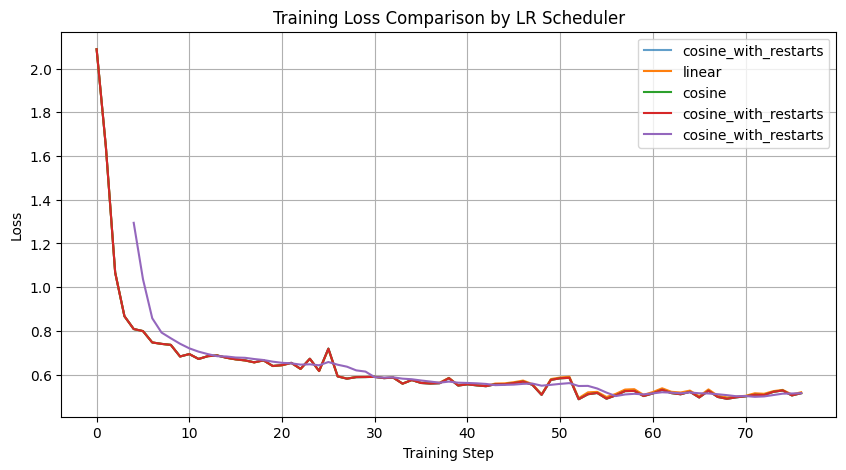

In [23]:
for scheduler, losses in loss_histories.items():
    print(f"{scheduler} → {len(losses)} steps")

def smooth(y, box_pts=5):
    return pd.Series(y).rolling(box_pts).mean()


# ALMOST IDENTICAL
# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label=scheduler, alpha=0.7)

for scheduler, losses in loss_histories.items():
    plt.plot(range(len(losses)), losses, label=scheduler)

plt.plot(smooth(losses), label=scheduler)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Comparison by LR Scheduler")
plt.legend()
plt.grid(True)
plt.show()


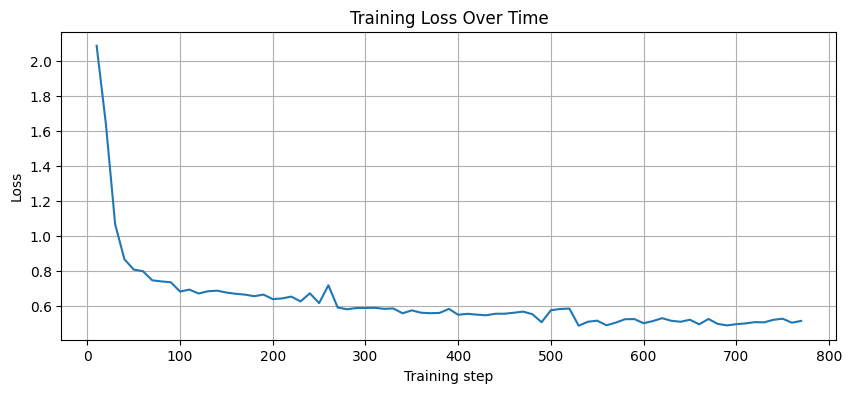

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)
logs.dropna(axis=1, how="all", inplace=True)

plt.figure(figsize=(10, 4))
plt.plot(logs["step"], logs["loss"])
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()


In [33]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
!ls -la


model = GPT2LMHeadModel.from_pretrained("./haiku-gpt2-cosine")
tokenizer = GPT2Tokenizer.from_pretrained("./haiku-gpt2-cosine")
tokenizer.pad_token = tokenizer.eos_token

generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0,
    eos_token_id=tokenizer.convert_tokens_to_ids("<EOS>")
)
prompt = "<HAIKU>\n<BOS>\n"
outputs = generator(prompt, max_length=64, num_return_sequences=5, do_sample=True, temperature=0.95)

# for i, o in enumerate(outputs):
#     print(f"\nHaiku {i+1} \n" + o["generated_text"])        # DIRTY OUTPUT

import re

def clean_output(text):
    # Grab text between <BOS> and <EOS>
    match = re.search(r"<BOS>\n(.+?)\n<EOS>", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return "[Invalid format]"

for i, o in enumerate(outputs):
    print(f"\nHaiku {i+1} \n" + clean_output(o["generated_text"]))


total 452
drwxr-xr-x 6 root root   4096 Apr 14 01:18 .
drwxr-xr-x 5 root root   4096 Apr 14 00:43 ..
drwxr-xr-x 2 root root   4096 Apr 14 01:18 haiku-gpt2-cosine
drwxr-xr-x 2 root root   4096 Apr 14 01:30 haiku-gpt2-cosine_with_restarts
drwxr-xr-x 2 root root   4096 Apr 14 01:06 haiku-gpt2-linear
-rw-r--r-- 1 root root 434619 Apr 14 00:54 haikus_from_dpo.txt
drwxr-xr-x 2 root root   4096 Apr 14 00:44 .virtual_documents


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Haiku 1 
Whispering leaves dance,
Nature's symphony in tune,
Spring's gentle heart.

Haiku 2 
Amber sun ascends,
Stillness embraces the universe,
Stillness in her embrace.

Haiku 3 
In the quiet night,
Lonely seagull dances on the branches,
Silent and unseen friend.

Haiku 4 
Moonlight on pond's edge,
Petals dance in the cold,
Nature's symphony.

Haiku 5 
Whispers of the breeze,
Vibrant kaleidoscope blooms,
Nature's art unfolds.


## Conclusion

Trained a GPT model specialized in haiku generation. After cleaning and filtering the dataset, the model now reliably outputs 3-line poems with a poetic tone.

### Sample Output:

> Ducks' song, so sweet  
> Petals dance in gentle breeze  
> Nature's sweet, free art

